In [18]:
# General imports 
import os 
import re
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as stats 
from skimage import measure
import matplotlib.pyplot as plt

# Pynwb imports
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget

In [19]:
# set data path
import sys
import platform
from os.path import join as pjoin

platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_dir = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_dir = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_dir = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_dir = "/media/$USERNAME/Brain2025/"
    
print('data directory set to', data_dir)

data directory set to /data/


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Metadata

The *bci_metadata.csv* file in the */data/metadata/* folder contains relevant information about the experimental session and the subject. 

In [20]:
# Load metadata csv file as pandas dataframe
metadata = pd.read_csv(os.path.join(data_dir, 'metadata', 'bci_metadata.csv'))
metadata.head()

,project_name,session_type,_id,name,subject_id,genotype,virus,date_of_birth,sex,modality,session_date,age,session_time,targeted_structure,ophys_fov,session_number
0,Brain Computer Interface,BCI single neuron stim,03f1b82e-4494-46bc-a959-50c4b14d13da,single-plane-ophys_731015_2025-01-28_17-40-57_...,731015,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,2024-03-14,Female,Planar optical physiology,2025-01-28,320,17:40:57.996000,Primary Motor Cortex,FOV_04,22.0
1,Brain Computer Interface,BCI single neuron stim,b28d6321-1b1b-4110-87fb-0e19325c1dfe,single-plane-ophys_767715_2025-02-17_17-41-50_...,767715,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,2024-09-15,Female,Planar optical physiology,2025-02-17,155,17:41:50.758000,Primary Motor Cortex,FOV_03,8.0
2,Brain Computer Interface,BCI single neuron stim,580448b2-4b93-4477-b6ac-6e2972792fe0,single-plane-ophys_772414_2025-01-27_15-57-05_...,772414,Camk2a-tTA/wt;tetO-GCaMP6s/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-10-15,Female,Planar optical physiology,2025-01-27,104,14:23:26.693000,Primary Motor Cortex,FOV_01,5.0
3,Brain Computer Interface,BCI single neuron stim,c1be8449-7bef-4967-88f5-6a6ffc29e5a3,single-plane-ophys_772414_2025-02-06_16-47-44_...,772414,Camk2a-tTA/wt;tetO-GCaMP6s/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-10-15,Female,Planar optical physiology,2025-02-06,114,16:47:44.152999,Primary Motor Cortex,FOV_02,13.0
4,Brain Computer Interface,BCI single neuron stim,15b395c0-1caf-4be4-a212-a13b9a4d1dfc,single-plane-ophys_772414_2025-02-10_11-15-26_...,772414,Camk2a-tTA/wt;tetO-GCaMP6s/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-10-15,Female,Planar optical physiology,2025-02-10,118,11:15:26.609999,Primary Motor Cortex,FOV_03,14.0


In [21]:
# Select data from one mouse
# Pick the first mouse
subject_ids = np.sort(metadata['subject_id'].unique())
subject_id = subject_ids[3]
print('Selected subject_id is', subject_id)

# Look at its metadata, sorted by 'session_number'
this_mouse_metadata = metadata[metadata['subject_id']==subject_id].sort_values(by='session_number')
this_mouse_metadata

Selected subject_id is 766719


,project_name,session_type,_id,name,subject_id,genotype,virus,date_of_birth,sex,modality,session_date,age,session_time,targeted_structure,ophys_fov,session_number
20,Brain Computer Interface,BCI single neuron stim,ea2ea4a7-8270-4712-bf5c-df7480cb276f,single-plane-ophys_766719_2025-01-22_16-45-18_...,766719,Camk2a-tTA/wt;TetO-jGCaMP8s-01/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-09-16,Female,Planar optical physiology,2025-01-22,128,15:36:39.563000,Primary Motor Cortex,FOV_01,2.0
21,Brain Computer Interface,BCI single neuron stim,e3e8dd63-0bc4-4fc7-aedf-2abe9416149f,single-plane-ophys_766719_2025-01-23_18-24-57_...,766719,Camk2a-tTA/wt;TetO-jGCaMP8s-01/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-09-16,Female,Planar optical physiology,2025-01-23,129,16:53:55.722000,Primary Motor Cortex,FOV_01,3.0
22,Brain Computer Interface,BCI single neuron stim,7ebc1acf-e7d2-4d04-9d59-e3556dfc107b,single-plane-ophys_766719_2025-01-27_18-25-39_...,766719,Camk2a-tTA/wt;TetO-jGCaMP8s-01/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-09-16,Female,Planar optical physiology,2025-01-27,133,17:02:50.868000,Primary Motor Cortex,FOV_01,5.0


In [22]:
# Let's pick the last session for this mouse
session_name = this_mouse_metadata.name.values[1]
print('Selected session is', session_name)

Selected session is single-plane-ophys_766719_2025-01-23_18-24-57_processed_2025-08-04_05-56-15


In [23]:
# Get the directory for this dataset and load it
bci_data_dir = os.path.join(data_dir, 'brain-computer-interface')
print(bci_data_dir)
# Get the data folder for this session
session_dir = os.path.join(bci_data_dir, session_name)
print(session_dir)
# Now find the NWB file and set the path to load it
nwb_file = [file for file in os.listdir(session_dir) if 'nwb' in file][0]
nwb_path = os.path.join(session_dir, nwb_file)
print(nwb_path)
# Load the data
# # io = NWBZarrIO(nwb_path, mode = 'r') 
# # nwbfile_zarr = io.read()
with NWBZarrIO(str(nwb_path), 'r') as io:
    nwbfile = io.read()
    print('Loaded NWB file from:', nwb_path)

/data/brain-computer-interface
/data/brain-computer-interface/single-plane-ophys_766719_2025-01-23_18-24-57_processed_2025-08-04_05-56-15
/data/brain-computer-interface/single-plane-ophys_766719_2025-01-23_18-24-57_processed_2025-08-04_05-56-15/single-plane-ophys_766719_2025-01-23_18-24-57_behavior_nwb


/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Loaded NWB file from: /data/brain-computer-interface/single-plane-ophys_766719_2025-01-23_18-24-57_processed_2025-08-04_05-56-15/single-plane-ophys_766719_2025-01-23_18-24-57_behavior_nwb


In [24]:
dir(nwbfile)

['_AbstractContainer__children',
 '_AbstractContainer__container_source',
 '_AbstractContainer__field_values',
 '_AbstractContainer__fieldsconf',
 '_AbstractContainer__gather_fields',
 '_AbstractContainer__modified',
 '_AbstractContainer__name',
 '_AbstractContainer__obj',
 '_AbstractContainer__object_id',
 '_AbstractContainer__parent',
 '_AbstractContainer__read_io',
 '_Container__smart_str',
 '_Container__smart_str_dict',
 '_Container__smart_str_list',
 '_MultiContainerInterface__add_article',
 '_MultiContainerInterface__build_class',
 '_MultiContainerInterface__build_conf_methods',
 '_MultiContainerInterface__join',
 '_MultiContainerInterface__make_add',
 '_MultiContainerInterface__make_constructor',
 '_MultiContainerInterface__make_create',
 '_MultiContainerInterface__make_get',
 '_MultiContainerInterface__make_getitem',
 '_MultiContainerInterface__make_getter',
 '_MultiContainerInterface__make_setter',
 '_NWBFile__check_electrodes',
 '_NWBFile__check_epochs',
 '_NWBFile__check_inv

In [25]:
nwbfile.session_description#["epochs"].to_dataframe()

'NWB file generated by AIND pipeline'

### Look at the conditions in this dataset

In [26]:
# Load the epochs table from the NWB file
epoch_table = nwbfile.intervals["epochs"].to_dataframe()
epoch_table

,stimulus_name,start_frame,stop_frame,start_time,stop_time
id,,,,,
0,photostim,0,142115,0.000000,2439.432587
1,spont,142116,146997,2439.449752,2523.233100
2,spont_01,146998,156243,2523.250265,2681.942552
3,spont_02,156244,161361,2681.959717,2769.794052
4,BCI,161362,228269,2769.811217,3918.283343
5,spont_post,228270,240081,3918.300508,4121.038701
6,photostim_post,240082,324142,4121.055866,5563.962690


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Overlay epochs with cell activity traces  
    
First load the `dff_traces` from the *<b>processing</b>* container of the NWB file. 

In [27]:
dff_traces = nwbfile.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].data
print('dff shape (nframes, nrois):',np.shape(dff_traces))
frame_rate = nwbfile.imaging_planes["processed"].imaging_rate
print('Frame Rate:', frame_rate)

dff shape (nframes, nrois): (324143, 3090)
Frame Rate: 58.2574


In [28]:
epoch_table = nwbfile.intervals["epochs"].to_dataframe()
epoch_table

,stimulus_name,start_frame,stop_frame,start_time,stop_time
id,,,,,
0,photostim,0,142115,0.000000,2439.432587
1,spont,142116,146997,2439.449752,2523.233100
2,spont_01,146998,156243,2523.250265,2681.942552
3,spont_02,156244,161361,2681.959717,2769.794052
4,BCI,161362,228269,2769.811217,3918.283343
5,spont_post,228270,240081,3918.300508,4121.038701
6,photostim_post,240082,324142,4121.055866,5563.962690


/tmp/ipykernel_478/2577709309.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Paired')


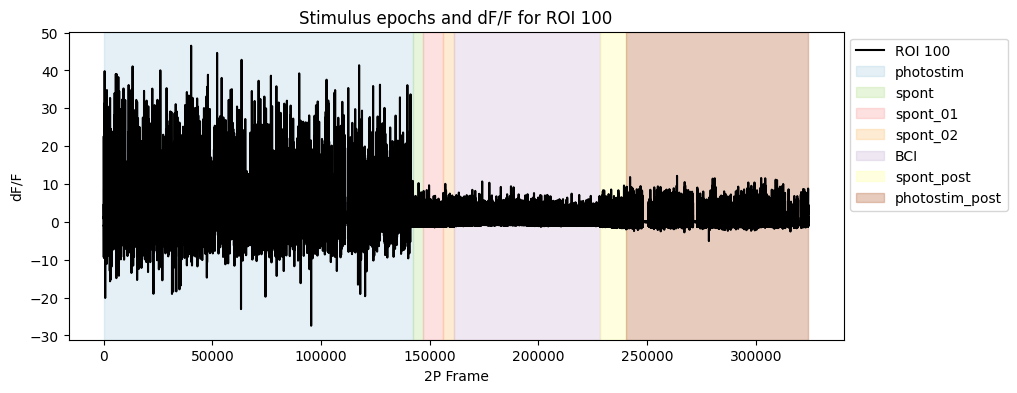

In [29]:
# Pick an ROI
ROI = 100

# Plot dff trace for selected ROI 
plt.rcParams["figure.figsize"] = (10, 4)
plt.plot(dff_traces[:, ROI], label=f'ROI {ROI}', color='black')

# Add shaded regions for stimulus epochs 
epoch_table = nwbfile.intervals["epochs"].to_dataframe()
stimulus_names = epoch_table.stimulus_name.unique()

import matplotlib.cm as cm
colors = cm.get_cmap('Paired')
colors = colors(np.linspace(0, 1, len(stimulus_names)))

                
for c, stimulus_name in enumerate(stimulus_names):
    stim_epoch = epoch_table[epoch_table.stimulus_name==stimulus_name]
    for j in range(len(stim_epoch)):
        plt.axvspan(xmin=stim_epoch.start_frame.iloc[j], xmax=stim_epoch.stop_frame.iloc[j], color=colors[c], alpha=0.3, label=stimulus_name)

plt.ylabel('dF/F')
plt.xlabel('2P Frame')
plt.title('Stimulus epochs and dF/F for ROI '+str(ROI))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

#### How to acces individual trials

Trials tables tell you what happened in each epoch. They can be found in the *<b>stimulus</b>* container of the NWB file. 

In [30]:
# These are the available trials tables
nwbfile.stimulus.keys()

dict_keys(['PhotostimTrials', 'Trials'])

In [31]:
photostim = nwbfile.stimulus["PhotostimTrials"].to_dataframe()
photostim.head()

,start_time,stop_time,start_frame,stop_frame,tiff_file,stimulus_name,laser_x,laser_y,power,duration,stimulus_function,group_index,closest_roi
id,,,,,,,,,,,,,
0,0.000000,2.214311,0,129,spont_slm_00001.tif,photostim,384.225806,162.322581,4,0.062,scanimage.mroi.stimulusfunctions.logspiral,35,2397
1,2.231476,4.548778,130,265,spont_slm_00002.tif,photostim,251.000000,13.475410,4,0.062,scanimage.mroi.stimulusfunctions.logspiral,18,288
2,4.565944,6.848915,266,399,spont_slm_00003.tif,photostim,205.107143,189.142857,4,0.062,scanimage.mroi.stimulusfunctions.logspiral,47,155
3,6.866081,9.149052,400,533,spont_slm_00004.tif,photostim,385.852941,142.529412,4,0.062,scanimage.mroi.stimulusfunctions.logspiral,13,115
4,9.166218,11.380528,534,663,spont_slm_00005.tif,photostim,153.777778,177.333333,4,0.062,scanimage.mroi.stimulusfunctions.logspiral,48,533


In [32]:
# Stimuli in photostim trials table
photostim['stimulus_name'].unique()

array(['photostim', 'photostim_post'], dtype=object)

In [33]:
bci_trials = nwbfile.stimulus["Trials"].to_dataframe()
bci_trials.head()

,start_time,stop_time,go_cue,hit,lick_L,reward_time,threshold_crossing_times,zaber_step_times,tiff_file,start_frame,stop_frame,conditioned_neuron_x,conditioned_neuron_y,closest_roi
id,,,,,,,,,,,,,,
0,2769.811217,2777.947523,0.2359,True,"[4.1397, 4.7706, 4.9562, 5.071000000000001, 5....",4.1397,4.1267,"[0.5710000000000001, 0.75, 0.9289, 1.1089, 2.6...",neuron22_00001.tif,161362,161836,334.348837,8.72093,81
1,2777.964688,2787.817513,0.2359,True,"[5.6859, 5.8547, 6.0491, 6.202100000000001, 6....",5.8547,5.7163,"[0.5531, 0.5891000000000001, 0.6241, 0.6701, 0...",neuron22_00002.tif,161837,162411,334.348837,8.72093,81
2,2787.834679,2799.747328,0.2359,True,"[7.7302, 7.9354, 8.126800000000001, 8.268, 8.3...",7.9354,7.7729,"[0.5743, 0.7023, 0.9313, 1.2803, 1.5042, 2.871...",neuron22_00003.tif,162412,163106,334.348837,8.72093,81
3,2799.764493,2811.299509,0.2359,True,"[7.5545, 7.9428, 8.1476, 8.3155, 8.59710000000...",NaN,NaN,"[0.6402, 1.1911, 1.7491, 4.152, 4.296, 6.7278,...",neuron22_00004.tif,163107,163779,334.348837,8.72093,81
4,2811.316674,2822.645707,0.2359,True,"[4.0099, 4.4469, 4.601100000000001, 4.6647, 4....",7.3433,7.1320,"[0.5684, 0.6754, 0.8254, 0.8774000000000001, 1...",neuron22_00005.tif,163780,164440,334.348837,8.72093,81


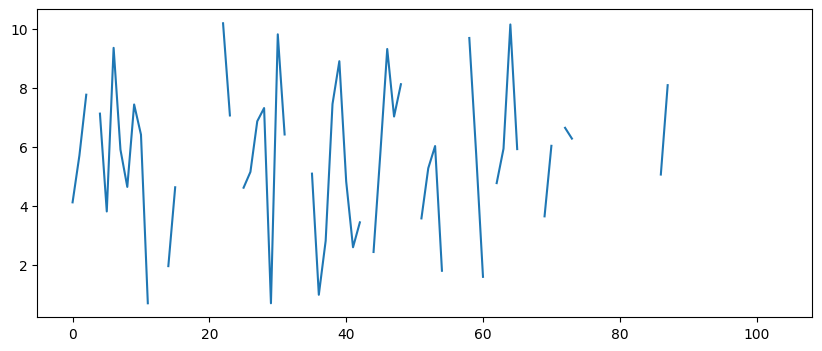

In [34]:
plt.plot(bci_trials['threshold_crossing_times'])

In [31]:
len(bci_trials)

90

In [32]:
bci_trials['closest_roi'].unique()

array([15])

In [33]:
correct_bci_trials = bci_trials[bci_trials['hit']==True]
correct_bci_trials.dropna(inplace=True,subset=['start_time', 'stop_time','threshold_crossing_times'])

In [34]:
correct_bci_trials

,start_time,stop_time,go_cue,hit,lick_L,reward_time,threshold_crossing_times,zaber_step_times,tiff_file,start_frame,stop_frame,conditioned_neuron_x,conditioned_neuron_y,closest_roi
id,,,,,,,,,,,,,,
0,1464.109544,1471.198042,0.2359,True,"[1.2136, 1.3187, 1.4325, 1.5603, 1.6652, 1.776...",1.2136,0.9780,"[0.5563, 0.5883, 0.6203000000000001, 0.6523, 0...",neuron22_00001.tif,85304,85717,353.5,59.131579,15
1,1471.215205,1481.084180,0.2359,True,"[1.7567000000000002, 1.895, 2.0081, 2.1212, 2....",1.7567,1.6231,"[0.3502, 0.4572, 0.6182000000000001, 0.8701000...",neuron22_00002.tif,85718,86293,353.5,59.131579,15
2,1481.101343,1489.597243,0.2359,True,"[0.0498, 3.8944, 4.0212, 4.1264, 4.2449, 4.350...",3.8944,2.9344,"[0.2866, 0.5486, 0.9735, 1.0616, 1.3175, 1.641...",neuron22_00003.tif,86294,86789,353.5,59.131579,15
3,1489.614406,1500.496023,0.2359,True,"[2.986, 3.1199000000000003, 3.2168, 3.33750000...",2.9860,2.8542,"[0.5562, 0.9442, 1.3551, 1.5781, 1.7741, 2.129...",neuron22_00004.tif,86790,87424,353.5,59.131579,15
4,1500.513187,1509.403845,0.2359,True,"[2.0717000000000003, 2.2657000000000003, 2.412...",2.2657,2.1475,"[0.2866, 0.3896, 0.4926, 0.6156, 0.76260000000...",neuron22_00005.tif,87425,87943,353.5,59.131579,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2426.514759,2439.713439,0.2359,True,"[9.1857, 9.3572, 9.5113, 9.6442, 9.7548, 9.855...",9.5113,9.4410,"[0.4735, 1.0385, 1.8044, 2.8034000000000003, 3...",neuron22_00085.tif,141377,142146,353.5,59.131579,15
85,2439.730603,2450.852508,0.2359,True,"[7.357900000000001, 7.466600000000001, 7.62130...",7.3579,7.1693,"[0.2867, 0.7057, 1.9716, 3.2795, 4.10950000000...",neuron22_00086.tif,142147,142795,353.5,59.131579,15
86,2450.869671,2462.249028,0.2359,True,"[6.7518, 6.8843000000000005, 7.0335, 7.1364, 7...",6.7518,6.7136,"[0.287, 0.462, 1.0079, 1.5379, 2.8038000000000...",neuron22_00087.tif,142796,143459,353.5,59.131579,15


In [20]:
# Get just the BCI epochs
BCI_epochs = epoch_table[epoch_table.stimulus_name.str.contains('BCI')]
BCI_epochs

,stimulus_name,start_frame,stop_frame,start_time,stop_time
id,,,,,
3,BCI,98595,160009,1692.228741,2746.303855


In [21]:
start_bci_epoch = BCI_epochs.loc[3].start_frame
stop_bci_epoch = BCI_epochs.loc[3].stop_frame
start_bci_trial = correct_bci_trials['start_frame']-start_bci_epoch
stop_bci_trial = correct_bci_trials['stop_frame']-start_bci_epoch
thrcrossframe_bci_trial = np.round(correct_bci_trials['threshold_crossing_times']*frame_rate).astype(int)
go_cue_bci = np.round(correct_bci_trials['go_cue']*frame_rate).astype(int)

In [105]:
bci_trials2 = bci_trials.dropna(inplace=False,subset=['start_time', 'stop_time'])
start_bci_epoch2 = BCI_epochs.loc[3].start_frame
stop_bci_epoch2 = BCI_epochs.loc[3].stop_frame
start_bci_trial2 = bci_trials2['start_frame']-start_bci_epoch2
stop_bci_trial2 = bci_trials2['stop_frame']-start_bci_epoch2


In [108]:
bci_trials

,start_time,stop_time,go_cue,hit,lick_L,reward_time,threshold_crossing_times,zaber_step_times,tiff_file,start_frame,stop_frame,conditioned_neuron_x,conditioned_neuron_y,closest_roi
id,,,,,,,,,,,,,,
0,1692.228741,1704.020019,0.2359,True,"[1.7861, 1.9033, 2.0241, 2.1415, 2.2464, 2.375...",1.7861,1.7089,"[0.3535, 0.5054000000000001, 0.6074, 0.7184, 0...",neuron119_00001.tif,98595,99282,108.633333,51.666667,124
1,1704.037183,1708.722800,0.2359,True,"[1.0667, 1.2012, 1.3251000000000002, 1.4520000...",1.0667,1.0582,"[0.2869, 0.3589, 0.4188, 0.4969, 0.5359, 0.577...",neuron119_00002.tif,99283,99556,108.633333,51.666667,124
2,1708.739964,1714.060628,0.2359,True,"[0.7160000000000001, 0.8175, 0.9416, 1.0605, 1...",0.8175,0.7399,"[0.3182, 0.3502, 0.3822, 0.4142, 0.4462, 0.478...",neuron119_00003.tif,99557,99867,108.633333,51.666667,124
3,1714.077792,1718.488794,0.2359,True,"[1.0345, 1.1526, 1.2687000000000002, 1.392, 1....",1.0345,0.9577,"[0.4984, 0.5503, 0.5874, 0.6204000000000001, 0...",neuron119_00004.tif,99868,100125,108.633333,51.666667,124
4,1718.505957,1725.869070,0.2359,True,"[1.3371, 1.4519, 1.5667, 1.6952, 1.8063, 1.932...",1.3371,1.3072,"[0.8276, 0.8886000000000001, 0.9356, 0.9736, 1...",neuron119_00005.tif,100126,100555,108.633333,51.666667,124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,2703.532578,2710.003192,0.2359,True,"[2.3146, 2.4226, 2.539, 2.6381, 2.7458, 2.8555...",2.3146,2.1648,"[0.2869, 0.3799, 0.5009, 0.6349, 0.8498, 1.000...",neuron119_00107.tif,157517,157894,108.633333,51.666667,124
107,2710.020356,2718.739380,0.2359,True,"[5.073, 5.2173, 5.3227, 5.433800000000001, 5.5...",5.0730,5.0670,"[0.7893, 3.0441000000000003, 3.2111, 3.3581000...",neuron119_00108.tif,157895,158403,108.633333,51.666667,124
108,2718.756544,2723.974227,0.2359,True,"[1.9804, 2.0903, 2.2122, 2.3263000000000003, 2...",1.9804,1.9732,"[0.2863, 0.3753, 0.4903, 0.6862, 0.8313, 0.976...",neuron119_00109.tif,158404,158708,108.633333,51.666667,124


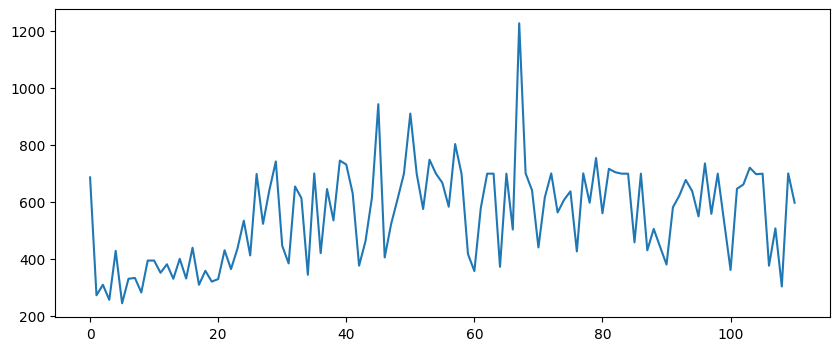

In [106]:
plt.plot(stop_bci_trial2-start_bci_trial2)

In [22]:
go_cue_bci.unique()

array([14])

### Read traces

In [23]:
# Get the dFF traces from the NWB file
dff_traces = nwbfile.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].data
# Look at the shape - the larger dimension are the 2P frames
print(dff_traces.shape)

(249370, 1736)


In [24]:
# Index into the dff traces array to limit to the relevant time points
dff_bci = dff_traces[start_bci_epoch:stop_bci_epoch, :]
# Now transpose so rows are ROI IDs
dff_bci = dff_bci.T
print(dff_bci.shape) # ROI by time

(1736, 61414)


Text(0.5, 1.0, 'BCI')

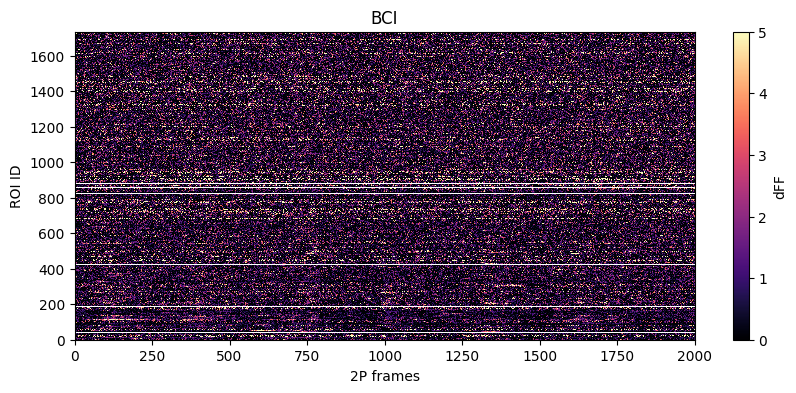

In [25]:
plt.pcolormesh(dff_bci[:,:2000], vmin=0, vmax=5, cmap='magma')
plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('ROI ID')
plt.title('BCI')

In [31]:
# Get the roi_table from the NWB file
roi_table = nwbfile.processing["processed"].data_interfaces["image_segmentation"].plane_segmentations["roi_table"].to_dataframe()
roi_table.head()

,is_soma,soma_probability,is_dendrite,dendrite_probability,image_mask
id,,,,,
0,0,0.000019,0,0.144048,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0,0.000021,0,0.000081,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0,0.219488,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,0,0.000000,0,0.000002,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1,0.999860,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [27]:
roi_table.iloc[124:125]

,is_soma,soma_probability,is_dendrite,dendrite_probability,image_mask
id,,,,,
124,0,2.682209e-07,0,5.960464e-08,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [44]:
# Remove ROIs with traces that are NaNs (note - this takes a few seconds)
valid_trace_ids = [i for i in range(dff_traces.shape[1]) if np.isnan(dff_traces[0, i])==False]
# Limit ROI table to non-NaN traces
roi_table2 = roi_table.loc[valid_trace_ids]

In [46]:
roi_table2

,is_soma,soma_probability,is_dendrite,dendrite_probability,image_mask
id,,,,,
1,0,2.056360e-05,0,8.112192e-05,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0,2.194884e-01,0,0.000000e+00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1,9.998604e-01,0,0.000000e+00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,0,1.989543e-03,0,0.000000e+00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
6,0,9.322166e-05,0,5.960464e-08,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...
1731,0,0.000000e+00,1,6.079142e-01,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1732,0,0.000000e+00,0,5.662441e-07,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1733,0,1.192093e-07,0,1.710653e-05,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [47]:
# Find the likely somatic ROIs
soma_probability = 0.005 # Emperically determined threshold - just trust us
# Limit to valid somatic ROIs
valid_rois = roi_table2[roi_table2.soma_probability>soma_probability]
valid_rois

,is_soma,soma_probability,is_dendrite,dendrite_probability,image_mask
id,,,,,
2,0,0.219488,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1,0.999860,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
10,1,0.999990,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
13,1,0.516982,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
14,0,0.225707,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...
1377,1,0.911253,1,0.994622,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1384,0,0.059563,1,0.965172,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1412,0,0.011402,0,0.010741,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [48]:
roi_table2.loc[124:125,:]

,is_soma,soma_probability,is_dendrite,dendrite_probability,image_mask
id,,,,,
124,0,2.682209e-07,0,5.960464e-08,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
125,1,5.876639e-01,0,0.000000e+00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [52]:
# Find the likely somatic ROIs
soma_probability = 0.005 # Emperically determined threshold - just trust us
# Limit to valid somatic ROIs
valid_rois = roi_table2[roi_table2.soma_probability>soma_probability]
valid_rois = pd.concat((valid_rois,roi_table2.loc[124:125,:]),axis=0).drop([125],inplace=False)
print('there are', len(valid_rois), 'ROIs with soma_probability >',soma_probability)

there are 226 ROIs with soma_probability > 0.005


In [53]:
valid_rois

,is_soma,soma_probability,is_dendrite,dendrite_probability,image_mask
id,,,,,
2,0,2.194884e-01,0,0.000000e+00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1,9.998604e-01,0,0.000000e+00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
10,1,9.999904e-01,0,0.000000e+00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
13,1,5.169820e-01,0,0.000000e+00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
14,0,2.257075e-01,0,0.000000e+00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...
1384,0,5.956331e-02,1,9.651724e-01,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1412,0,1.140219e-02,0,1.074126e-02,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1417,0,8.536100e-03,0,7.271767e-06,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [65]:
valid_rois.index.values

array([   2,    4,   10,   13,   14,   16,   17,   18,   20,   23,   24,
         26,   27,   29,   30,   31,   33,   34,   35,   37,   38,   39,
         42,   43,   44,   47,   49,   51,   52,   53,   54,   55,   56,
         58,   61,   62,   65,   67,   69,   71,   72,   73,   74,   76,
         83,   84,   85,   86,   90,   94,   95,   96,   97,   98,   99,
        101,  102,  103,  104,  105,  108,  111,  112,  115,  118,  119,
        120,  121,  122,  123,  132,  136,  137,  138,  142,  145,  146,
        147,  151,  152,  153,  154,  160,  161,  163,  164,  167,  170,
        173,  177,  178,  179,  180,  182,  183,  185,  189,  190,  191,
        192,  198,  199,  200,  202,  205,  206,  207,  212,  219,  220,
        224,  225,  226,  227,  228,  229,  231,  232,  233,  235,  237,
        238,  240,  241,  242,  247,  248,  249,  252,  254,  256,  257,
        266,  268,  272,  274,  275,  281,  282,  284,  285,  288,  297,
        298,  300,  302,  304,  307,  308,  309,  3

In [66]:
dff_bci[124]

array([-1.198824  ,  4.4784317 ,  0.79646415, ..., -0.92755884,
        3.9180765 , -0.5431086 ], shape=(61414,), dtype=float32)

In [54]:
# Limit dff traces for spontaneous activity period before the task to valid ROIs
dff_bci_valid = dff_bci[valid_rois.index.values, :]
print(dff_bci_valid.shape)

(226, 61414)


Text(0.5, 1.0, 'BCI')

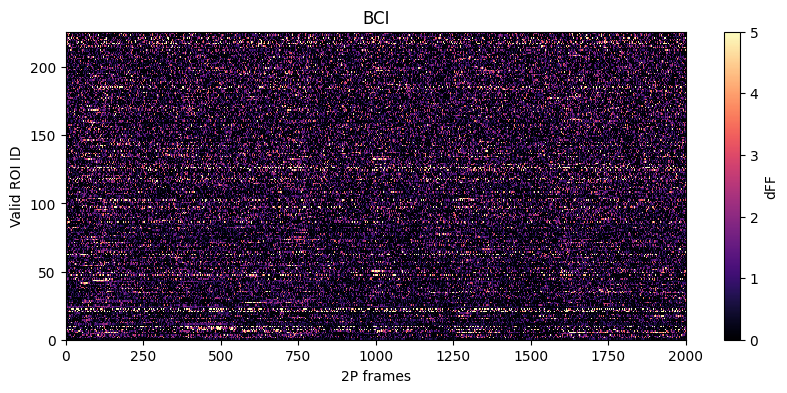

In [55]:
plt.pcolormesh(dff_bci_valid[:,:2000], vmin=0, vmax=5, cmap='magma')
plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('Valid ROI ID')
plt.title('BCI')

In [56]:
# Organize data by trials
n_rois = dff_bci_valid.shape[0]
n_trials = len(start_bci_trial)

max_tr_duration = np.max(stop_bci_trial-start_bci_trial)

storage = np.full((n_rois,n_trials,max_tr_duration),np.nan)
    
for itr,(ist,istp) in enumerate(zip(start_bci_trial,stop_bci_trial)):

    storage[:,itr,:int(istp-ist)] = dff_bci_valid[:,ist:istp]

In [69]:
storage.shape

(226, 93, 1228)

Text(0.5, 1.0, 'BCI ROI nº225')

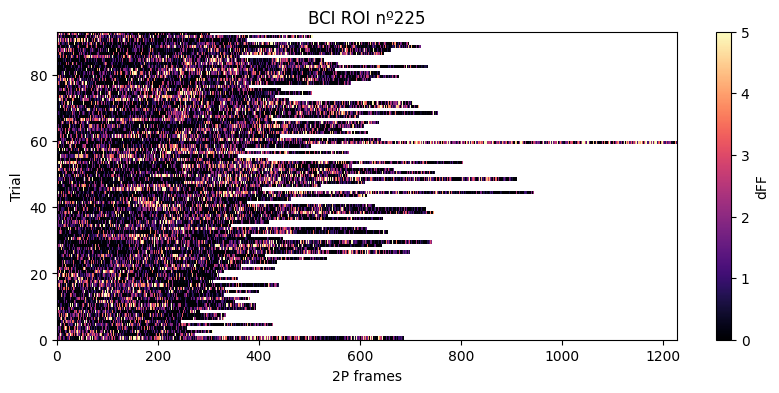

In [71]:
i_roi = 225
plt.pcolormesh(storage[i_roi], vmin=0, vmax=5, cmap='magma')
plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('Trial')
plt.title(f'BCI ROI nº{i_roi}')

In [72]:
def indep_roll(
    arr: np.ndarray, shifts: np.ndarray, axis: int = 1
) -> np.ndarray:
    """Apply an independent roll for each dimensions of a single axis.
    Args:
        arr (np.ndarray): Array of any shape.
        shifts (np.ndarray): How many shifting to use for each dimension. Shape: `(arr.shape[axis],)`.
        axis (int, optional): Axis along which elements are shifted. Defaults to 1.

    Returns:
        np.ndarray: shifted array.
    """
    arr = np.swapaxes(
        arr, axis, -1
    )  # Move the target axis to the last position
    all_idcs = np.ogrid[
        [slice(0, n) for n in arr.shape]
    ]  # Create grid indices
    shifts[shifts < 0] += arr.shape[-1]  # Convert to a positive shift
    new_indices = all_idcs[-1] - shifts[:, np.newaxis]
    result = arr[tuple(all_idcs[:-1]) + (new_indices,)]
    arr = np.swapaxes(result, -1, axis)
    return arr

In [73]:
storage.shape

(226, 93, 1228)

In [74]:
# Let's align on threshold_crossing_times
frames_before = 560
shifts = thrcrossframe_bci_trial.values -frames_before
dff_bci_alignon_thr = indep_roll(storage,-shifts,axis=-1)

Text(0.5, 1.0, 'BCI ROI nº225')

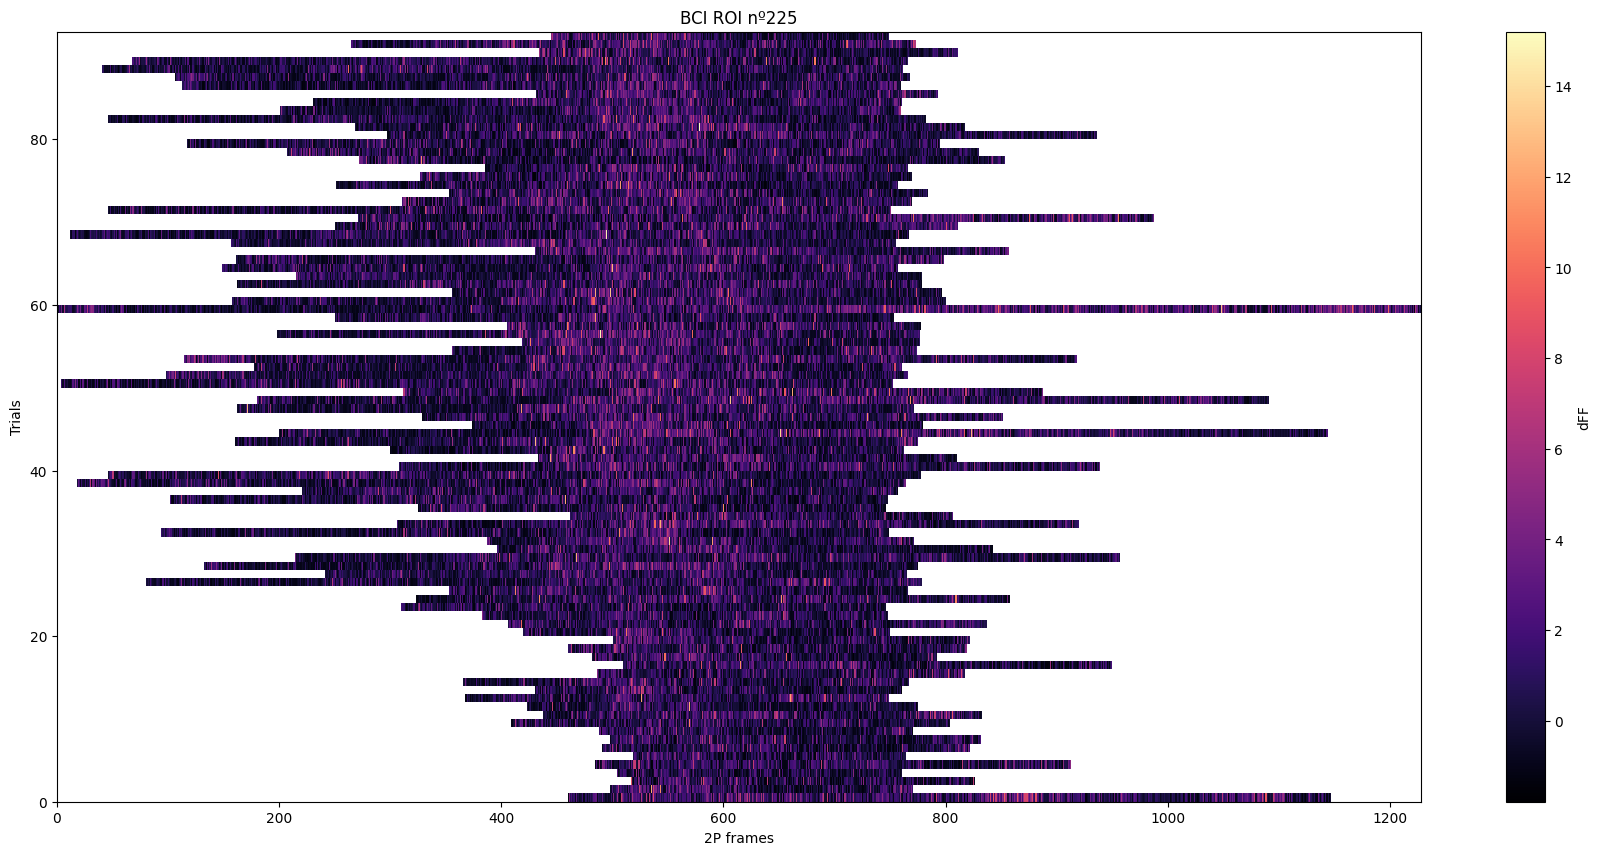

In [84]:
i_roi = 225
fig,ax=plt.subplots(figsize=(22,10))
plt.pcolormesh(dff_bci_alignon_thr[i_roi],cmap='magma')
plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('Trials')
plt.title(f'BCI ROI nº{i_roi}')

In [76]:
np.nanmean(dff_bci_alignon_thr,axis=1).shape

(226, 1228)

Text(0.5, 1.0, 'BCI avg')

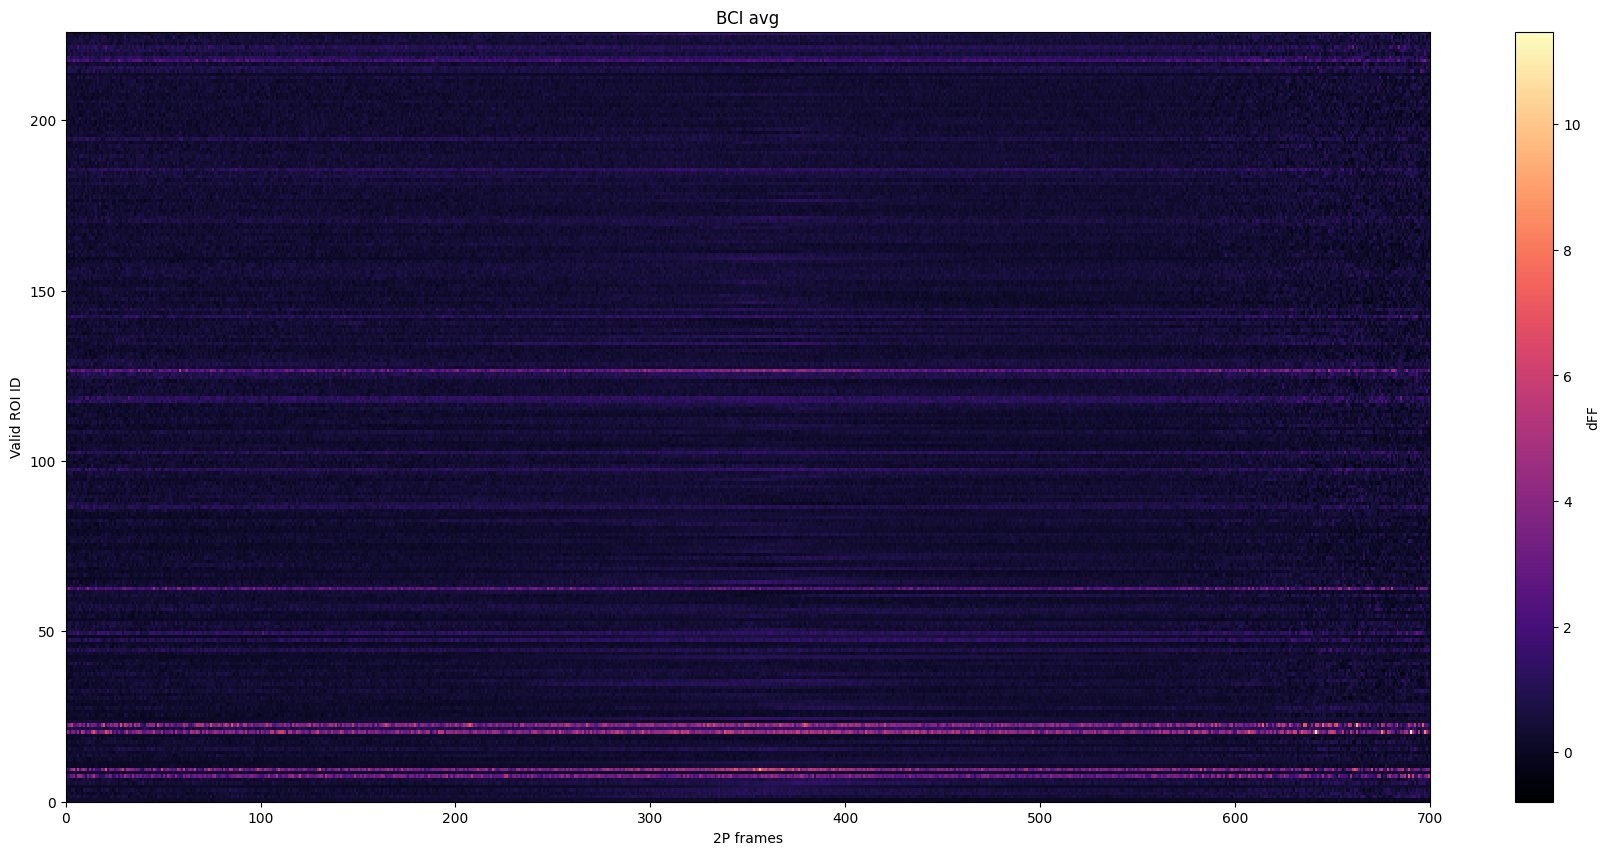

In [82]:
fig,ax=plt.subplots(figsize=(22,10))
plt.pcolormesh(np.nanmean(dff_bci_alignon_thr,axis=1)[:,200:900], cmap='magma')
plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('Valid ROI ID')
plt.title(f'BCI avg')

In [155]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [164]:
dff_bci_alignon_thr.shape

(226, 93, 1228)

In [179]:
pca = PCA(n_components=0.75)

In [180]:
x.shape

(400, 226)

In [181]:
x=(np.nanmean(dff_bci_alignon_thr,axis=1)[:,400:800]).T
X_scaled = StandardScaler().fit_transform(x)
pca.fit(X_scaled)

,n_components,0.75
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [184]:
print(pca.explained_variance_ratio_)
print(len(pca.explained_variance_ratio_))

[0.17896437 0.07217381 0.02543154 0.01882011 0.01332486 0.01134219
 0.01029398 0.01006539 0.01000899 0.00993333 0.00957373 0.00942618
 0.00924693 0.00917356 0.00901552 0.00874786 0.00865419 0.00855101
 0.00834926 0.00826344 0.0081341  0.00800615 0.00793938 0.00779428
 0.00766516 0.00758191 0.00745466 0.00733174 0.00728534 0.00718299
 0.00707977 0.0069001  0.00687736 0.00679833 0.00667254 0.0065164
 0.00647712 0.00635656 0.00619204 0.00613514 0.00608377 0.00598509
 0.00593738 0.0058948  0.00582687 0.00569584 0.00564152 0.00558349
 0.00555265 0.00544398 0.00541318 0.00522738 0.00520488 0.00511191
 0.00504054 0.00500501 0.00494171 0.00489209 0.00486281 0.00473453
 0.0047084  0.00462526 0.00460046 0.00453085 0.00445297 0.00439252
 0.00433157 0.00431555 0.00426352 0.00421554 0.00417984 0.00412982]
72


In [193]:
frame_rate

np.float64(58.2634)

In [176]:
x_trans = pca.transform(X_scaled)

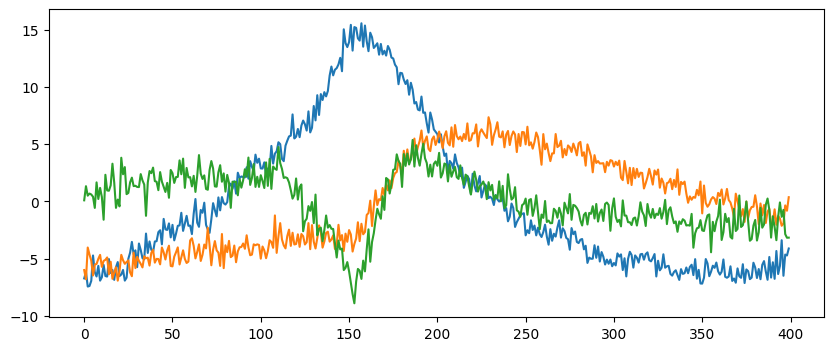

In [192]:
plt.plot(x_trans[:,:3])

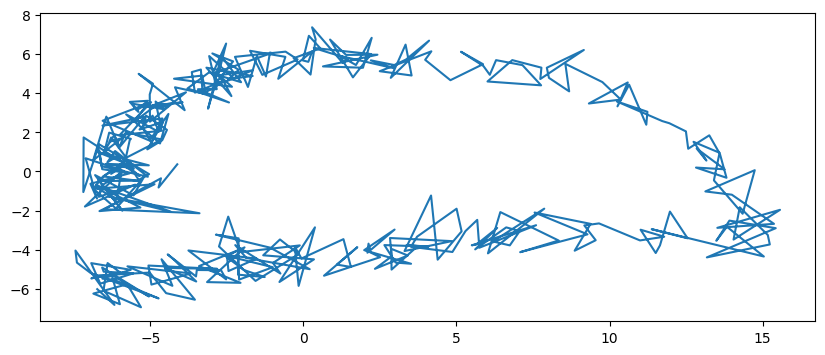

In [191]:
plt.plot(x_trans[:,0],x_trans[:,1])

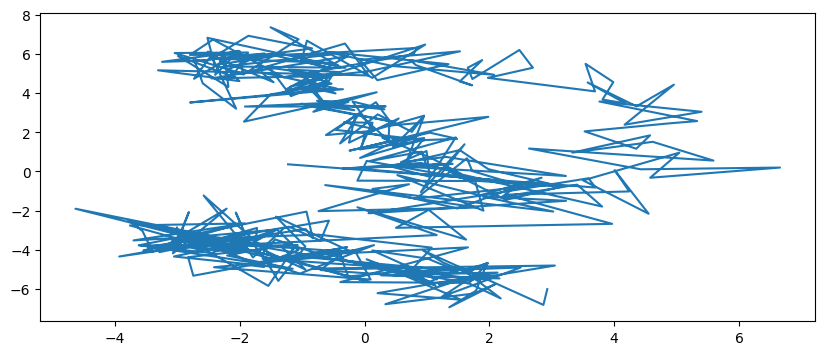

In [189]:
plt.plot(x_trans[:,3],x_trans[:,1])